In [ ]:
import os
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional
from PIL import Image

class PreTrainDataset(Dataset):
    def __init__(self,
                 test_doc_id_list,
                 test_mode=False,
                 # input_path='../kuzushiji_recognition/synthetic_images/input_images/',
                 input_path='../kuzushiji_recognition/synthetic_images/tmp_entire_data/',
                 json_path='../kuzushiji_recognition/synthetic_images/gt_json.json',
                 transform=None,
                 image_downsample_rate=10):
        super().__init__()
        self.test_doc_id_list = test_doc_id_list
        self.input_path = input_path
        self.transform = transform
        self.image_downsample_rate = image_downsample_rate
        
        # 画像のIDをリストにして保管。
        self.input_imageID_list = []
        for file_name in os.listdir(self.input_path):
            file_path = os.path.join(self.input_path, file_name)
            if os.path.isfile(file_path):
                # test_modeに応じて、テスト用データと学習用データを切り分ける
                # XOR (^) を利用:
                # - test_mode=False (学習時): doc_idがtest_listにない(False) -> 全体はFalse -> 読み込む
                # - test_mode=True (テスト時): doc_idがtest_listにある(True) -> 全体はFalse -> 読み込む
                if not (file_name.split('_sep_')[0] in self.test_doc_id_list) ^ test_mode:
                    self.input_imageID_list.append(file_name.split('.')[0])
        
        # アノテーションデータを保持するjsonファイルをロード
        self.gt_json = self.load_GT_json(json_path)

        # 入力画像に対応するアノテーションデータが存在するか確認。(コメントアウト)
        # for i in range(len(self.input_imageID_list)-1, -1,-1):
        #     if not self.input_imageID_list[i] in self.gt_json:
        #         del self.input_imageID_list[i]

    def __len__(self):
        return len(self.input_imageID_list)

    def __getitem__(self, index):
        image_id = self.input_imageID_list[index]
        image = Image.open(self.input_path + image_id + '.jpg')
        
        # 正解マップを復元 (4チャネルの torch tensor を出力)
        tensor_gt = self.return_tensor_gt(gt_info_dic=self.gt_json['files'][image_id], image=image)

        # 1. 元の画像のサイズを取得
        original_w, original_h = image.size
        
        # 2. ターゲットとなる新しいサイズを計算
        new_size = (original_h // self.image_downsample_rate, original_w // self.image_downsample_rate)
        
        # 3. functional.resizeを使って、入力画像と正解データの両方をリサイズ
        #    補間方法(interpolation)は、連続値なので両方ともBILINEAR(双線形補間)が適しています。
        image = functional.resize(image, new_size, interpolation=functional.InterpolationMode.BILINEAR)
        tensor_gt = functional.resize(tensor_gt, new_size, interpolation=functional.InterpolationMode.BILINEAR)

        if self.transform:
            image = self.transform(image)
            
        return image, tensor_gt

    def load_GT_json(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print("json データを読み込みました。")
        return data

    def return_ground_truth_canvas(self, image):
        w, h = image.size
        main_region = np.zeros((h, w), dtype=np.float64)
        main_affinity = np.zeros((h, w), dtype=np.float64)
        furi_region = np.zeros((h, w), dtype=np.float64)
        furi_affinity = np.zeros((h, w), dtype=np.float64)
        return main_region, main_affinity, furi_region, furi_affinity

    def add_perspective_gaussian_to_canvas(self, canvas, points, amplitude=1.0):
        # 領域の4点を取得
        src_points = np.array(points, dtype=np.float32)

        # ガウス分布を生成するための仮想的な正方形領域を定義
        width = int(max(np.linalg.norm(src_points[0] - src_points[1]), np.linalg.norm(src_points[2] - src_points[3])))
        height = int(max(np.linalg.norm(src_points[0] - src_points[3]), np.linalg.norm(src_points[1] - src_points[2])))
        dst_points = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype=np.float32)

        # ガウス分布を生成
        x = np.linspace(-width / 2, width / 2, width)
        y = np.linspace(-height / 2, height / 2, height)
        x, y = np.meshgrid(x, y)
        sigma_x = width / 5.0
        sigma_y = height / 5.0
        gaussian = amplitude * np.exp(-((x**2) / (2 * sigma_x**2) + (y**2) / (2 * sigma_y**2)))

        # Perspective Transformation行列を計算
        matrix = cv2.getPerspectiveTransform(dst_points, src_points)

        # ガウス分布をPerspective Transformationで変形
        transformed_gaussian = cv2.warpPerspective(gaussian, matrix, (canvas.shape[1], canvas.shape[0]))

        # キャンバスにガウス分布を追加
        canvas += transformed_gaussian

        return canvas

    def design_gaussian_map(self, canvas, point_list):
        for points in point_list:
            p1x, p1y, p2x, p2y, p3x, p3y, p4x, p4y = points
            self.add_perspective_gaussian_to_canvas(canvas, ((p1x, p1y), (p2x, p2y), (p3x, p3y), (p4x, p4y)), amplitude=1.0)
        return canvas

    def return_tensor_gt(self, gt_info_dic, image):
        main_region, main_affinity, furi_region, furi_affinity = self.return_ground_truth_canvas(image)

        # <main_region, main_affinity, furi_region, furi_affinity をgt_info に基づいてデザイン>
        canvas_list = []
        canvas_map = {
            'main_region': main_region,
            'main_affinity': main_affinity,
            'furi_region': furi_region,
            'furi_affinity': furi_affinity
        }
        
        for name, canvas in canvas_map.items():
            if name in gt_info_dic:
                canvas_list.append(self.design_gaussian_map(canvas, gt_info_dic[name]))

        # <それぞれをtorch tensor に変換して、4チャネルのtorch tensorへ>
        tensor_list = []
        for canvas in canvas_list:
            tensor_list.append(torch.from_numpy(canvas.astype(np.float32)).clone())
        
        return_tensor = torch.stack(tensor_list)
        return return_tensor
    

In [ ]:

import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
import torch
from torchvision import transforms
import matplotlib.pyplot as plt


In [7]:
test_doc_id_list = ['100241706', '100249371', '100249376', '100249416', '100249476', '100249537', '200003076', '200003803', '200003967', '200004107']
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = PreTrainDataset(
    input_path='../../kuzushiji-recognition/synthetic_images/input_images/',
    json_path='../../kuzushiji-recognition/synthetic_images/gt_json.json',
    test_doc_id_list=test_doc_id_list,
    test_mode=False,
    # device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    # precompute_gt=False,
    transform=transform,
    # target_width=400  # 横幅を400ピクセルに固定
)

json データを読み込みました。


In [9]:
first_data = dataset[0]

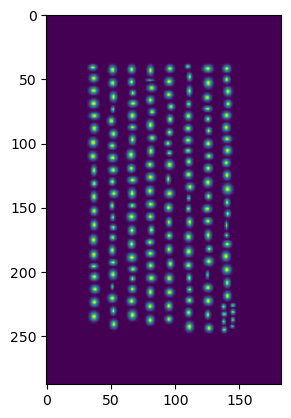

In [19]:
type(first_data[0].size())
first_data[1].size()
# len(first_data)
plt.imshow(first_data[1][0])